In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", 'F-score is ill-defined and being set to 0.0 due to no predicted samples')

from sklearn.metrics import roc_curve, auc
from scipy import interp

from sklearn.svm import OneClassSVM

np.random.seed(42)

# Quickbird Diseased Trees
## Author: Mihail Kalachev

### Abstract

In this paper I examine two datasets containing information from images of Earth, taken from QuickBird Satellite Sensor. QuickBird satellite collected image data to 0.65m pixel resolution degree of detail. This satellite was an excellent source of environmental data useful for analyses of changes in land usage, agricultural and forest climates. The data sets consist of image segments, generated by segmenting the pansharpened image. The segments contain spectral information from the Quickbird multispectral image bands and texture information from the panchromatic (Pan) image band. The main question that I am trying to answer is:

#### Can we train a Machine Learning algorithm to recognize areas of diseased trees based on the image data from QuickBird Satellite Sensor?

### Obtain, Scrub and Explore the  datasets

Let's first get a hold of our data and see what we are dealing with. The train and test datasets were already separated for us.

In [2]:
tree_data_train = pd.read_csv("training.csv")
tree_data_test = pd.read_csv("testing.csv")

In [3]:
tree_data_train.head()

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,w,120.362774,205.500000,119.395349,416.581395,20.676318
1,w,124.739583,202.800000,115.333333,354.333333,16.707151
2,w,134.691964,199.285714,116.857143,477.857143,22.496712
3,w,127.946309,178.368421,92.368421,278.473684,14.977453
4,w,135.431548,197.000000,112.690476,532.952381,17.604193


In [4]:
tree_data_test.head()

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,n,109.828571,183.700000,82.950000,251.750000,16.079412
1,n,130.284483,212.637931,96.896552,482.396552,21.210295
2,n,131.386555,185.466667,85.466667,419.666667,13.339998
3,n,141.345098,180.875000,81.500000,348.062500,18.213577
4,w,121.383408,218.357143,112.017857,426.607143,19.083196


The features are only 5 and are all numeric, which is great, they may need some scaling later on to improve the results of our Classification algorithms. Also we will need to shuffle the data, because it seems our positive training observations are all listed in the beginning of the dataset.

Let's describe the datasets to see how the values are distributed.

In [5]:
tree_data_train.describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,126.831298,233.906908,117.292439,534.104683,24.924588
std,13.735836,60.757687,60.711159,154.495500,11.008303
min,0.000000,164.625000,59.142857,86.500000,0.000000
25%,118.589080,206.000000,91.975244,422.875000,18.009143
50%,127.479167,221.454545,101.727273,528.500000,23.612444
75%,135.043591,241.791304,116.866071,643.087037,29.899148
max,183.281250,955.714286,746.333333,1005.516129,156.508431


In [6]:
tree_data_test.describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,127.065977,209.767564,107.739215,453.734870,20.641288
std,10.667542,78.677763,71.773037,156.198323,6.757322
min,81.125000,117.210526,50.578947,144.875817,5.772400
25%,119.978475,188.892662,85.511304,341.588922,15.853416
50%,127.532191,203.626923,99.828421,443.719444,20.028992
75%,133.799711,218.965116,118.054555,542.959928,24.121108
max,167.944444,1848.916667,1594.583333,1597.333333,62.396581


There is something a bit odd here. The testing dataset has different mean, std and quartile values for some of the features than the training dataset. Although we cannot be sure of anything at this point, we may face a situation where the testing dataset contains points in a region of the 5-dimentional space that our algorithm has never seen and can only try to guess them by extrapolation which will reduce its performance and scoring metrics. Let's try to draw a slice of this 5 dimentional space let's say for `Mean_Red` and `Mean_NIR` features.

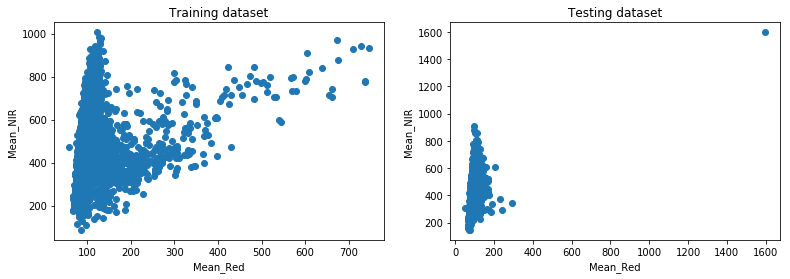

In [7]:
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.scatter(tree_data_train["Mean_Red"], tree_data_train["Mean_NIR"])
plt.title("Training dataset")
plt.xlabel("Mean_Red")
plt.ylabel("Mean_NIR")
plt.subplot(1, 2, 2)
plt.scatter(tree_data_test["Mean_Red"], tree_data_test["Mean_NIR"])
plt.title("Testing dataset")
plt.xlabel("Mean_Red")
plt.ylabel("Mean_NIR")
plt.show()

For this slice of the 5-dimentional space, the training and testing datasets seem to follow a similar structure, the only difference I could notice is the outlier in the testing dataset, which should not be a problem during the scoring of our alrorithm, because 1 incorrectly classified observation is nothing. Let's zoom in to see:

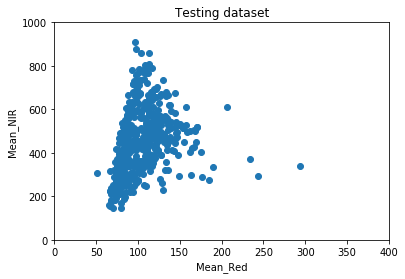

In [8]:
plt.scatter(tree_data_test["Mean_Red"], tree_data_test["Mean_NIR"])
plt.title("Testing dataset")
plt.xlabel("Mean_Red")
plt.ylabel("Mean_NIR")
plt.xlim(0, 400)
plt.ylim(0, 1000)
plt.show()

The structure looks similar to the training dataset. Ok, moving on. Checking the size.

In [9]:
print(tree_data_train.shape)
print(tree_data_test.shape)

(4339, 6)
(500, 6)


The testing set is roughly 10 percent of the whole data that is available to us. Let's see the class distribution.

In [10]:
print(tree_data_train.groupby("class").size())
print(tree_data_test.groupby("class").size())

class
n    4265
w      74
dtype: int64
class
n    313
w    187
dtype: int64


This is not good. First of all the data is very imbalanced. Second, we have __only 74__ positive observations in the training dataset, which may turn up as a problem where our algorithm will not be able to generalize well enough. Anyway let's see what we can do with such a data distribution.

Checking the datatypes and for NaN values:

In [11]:
print(tree_data_train.dtypes)
print(tree_data_test.dtypes)

class          object
GLCM_pan      float64
Mean_Green    float64
Mean_Red      float64
Mean_NIR      float64
SD_pan        float64
dtype: object
class          object
GLCM_pan      float64
Mean_Green    float64
Mean_Red      float64
Mean_NIR      float64
SD_pan        float64
dtype: object


In [12]:
print(tree_data_train.isnull().values.any())
print(tree_data_test.isnull().values.any())

False
False


No NaN values, all features are numeric, the category is a string, great.

### Preparing the data for ML training

First of all let's separate the features from the class we are trying to predict.

In [13]:
tree_features_train = tree_data_train.drop("class", axis = 1)
tree_labels_train = tree_data_train["class"]
tree_features_test = tree_data_test.drop("class", axis = 1)
tree_labels_test = tree_data_test["class"]

Now let's make the class numeric. We only have 2 values so the positive one will be 1 and the negative one - 0

In [14]:
encode_labels = {"w": 1, "n": 0}

tree_labels_train = tree_labels_train.replace(encode_labels)
tree_labels_test = tree_labels_test.replace(encode_labels)

As we saw earlier, the features may need some scaling and most classification algorithms work far better on scaled data. There are a number of scaling algorightms, we choose to work with a StandardScaler which scales the data following a normal distribution. We need to scale both the training and testing features.

In [15]:
scaler = StandardScaler()
tree_features_train = pd.DataFrame(scaler.fit_transform(tree_features_train), index = tree_features_train.index, columns = tree_features_train.columns)
tree_features_test = pd.DataFrame(scaler.fit_transform(tree_features_test), index = tree_features_test.index, columns = tree_features_test.columns)

### ML Training 

Now we've reached the center theme of our paper - the actual ML training. First let's define a function that we will use numerous times, performing Grid Search on different models. The function performs Cross Validation Grid Search which definitely needs to be stratified given the huge imbalance in our data. We also shuffle the data each time, because our positive observations are all listed in the beginning of the training dataset.

In [16]:
def grid_search_cv(model, params_to_tune, score_function, k_fold_splits, attributes, labels):
    """
    Perform Grid Search with Stratified Cross Validation on given model with the given hyperparameters,
    number of CV K-folds and a scoring function to use on the given attribute and label datasets.
    
    Returns the result from the call to GridSearchCV with the given parameters.

    Parameters
    ----------
    model :
        A classification algorithm to be used in the Grid Search
        
    params_to_tune :
        Hyperparameters for the model to be tried in the Grid Search
        
    score_function :
        scoring function to be used when estimating the best model
        
    k_fold_splits :
        Number of cross validation folds to be used in the Stratified K-fold split
        
    attributes :
        The features dataset
        
    labels :
        The labels dataset containing the actual class
    """
    
    skf = StratifiedKFold(n_splits = k_fold_splits, shuffle = True)
    k_fold = skf.split(attributes, labels)
    
    grid_search = GridSearchCV(model, params_to_tune, scoring = score_function, cv = k_fold)
    grid_search.fit(attributes, labels)
    
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    
    return grid_search

We are all set to go. For number of k-fold splits we will use 5. It may be a bit too much given how little our positive observations are, but I've tried with 3 and got the same results. For a scoring function we cannot use the standard score which uses accuracy as a measure, because of how imbalanced our data is. We will use F1 score, which uses both precision and recall in its definition. Later on we will check each one of those score metrics separately. For now F1 seems perfect for a rough estimation of how good a model is.

The models we try are:

1. Logistic Regression.
2. Decision Tree.
3. Random Forest ensemble algorithm.
4. Linear Support Vector Machine.
5. Support Vector Machine with a kernel.

In [17]:
tuned_params = [{"C": [0.0001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                 "max_iter": [50, 100, 300, 1000],
                 "fit_intercept":[True, False]}]

grid_search_logistic = grid_search_cv(model = LogisticRegression(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'C': 1000, 'fit_intercept': True, 'max_iter': 50}
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6814327614972926


In [18]:
tuned_params = [{"max_depth": [1, 5, 7, 15, 20],
                 "min_samples_leaf": [2, 5, 10, 12],
                 "max_leaf_nodes":[5, 10, 20]}]

grid_search_dtree = grid_search_cv(model = DecisionTreeClassifier(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 5}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.7234113969306409


In [19]:
tuned_params = [{"n_estimators": [100, 200, 300],
                 "max_depth": [20, 50, 100]}]

grid_search_forest = grid_search_cv(model = RandomForestClassifier(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'max_depth': 100, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.7323072503849481


In [20]:
tuned_params = [{"C": [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20]}]

grid_search_lsvc = grid_search_cv(model = LinearSVC(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'C': 20}
LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.6577148715340417


In [21]:
tuned_params = [{"C": [10, 15, 20, 50, 200],
                 "gamma": [0.001, 0.01, 0.1, 0.2]}]

grid_search_svc = grid_search_cv(model = SVC(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'C': 50, 'gamma': 0.1}
SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8956514527319814


The model with the best F1 score is Support Vector Machine with a kernel. It gave us a 0.896 F1 score.

To get an estimation of how good the training of this model went, let's draw the Learning curve. For this, we define another function which given the model and the training datasets draws the learning curve of the training of the model.

In [22]:
def plot_learning_curve(estimator, title, X, y, k_fold_splits, ylim = None,
                        n_jobs = None, train_sizes = np.linspace(.1, 1.0, 5), scoring_function = "f1"):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    k_fold_splits : int, Number of cross validation folds to be used in the Stratified K-fold split
    
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    skf = StratifiedKFold(n_splits = k_fold_splits, shuffle = True)
    k_fold = skf.split(X, y)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = k_fold, n_jobs = n_jobs, train_sizes = train_sizes, scoring = scoring_function)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")

    plt.legend(loc = "best")
    plt.show()

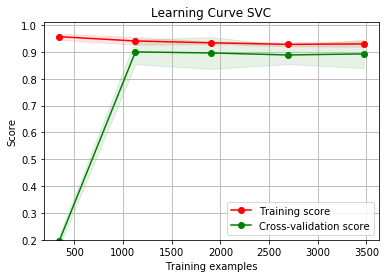

In [23]:
plot_learning_curve(estimator = grid_search_svc.best_estimator_,
                    title = "Learning Curve SVC",
                    X = tree_features_train,
                    y = tree_labels_train,
                    k_fold_splits = 5,
                    ylim=(0.2, 1.01),
                    n_jobs=4,
                    train_sizes = np.linspace(.1, 1.0, 5),
                    scoring_function = "f1")

Very early on, the CV score nears the training score and does not improve much with time. Which means that we didn't need more than 1000 observations to train our model. The 2 lines are very close to each other but both have a relatively high F1 score. So we are **not** suffering from high bias. It looks like we created a perfect model at 1000 observations early on. But will this model be able to generalize well enough on the testing dataset? Let's check that for all the models that we trained.

In [24]:
print(f1_score(tree_labels_test, grid_search_logistic.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_dtree.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_forest.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_lsvc.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_svc.predict(tree_features_test)))

0.0
0.10101010101010101
0.010638297872340425
0.0
0.13930348258706465


Horrible. The training dataset got ~0.89 F1 score on the SVC model, while the testing dataset produced ~0.14 F1 score. Usually this is a sign of overfitting. We fit the training data perfectly, but got awful results from the test data. Let's check some other metrics to draw conclusions.

In [25]:
precision_recall_fscore_support(tree_labels_test, grid_search_svc.best_estimator_.predict(tree_features_test))

(array([0.64403292, 1.        ]),
 array([1.        , 0.07486631]),
 array([0.78347935, 0.13930348]),
 array([313, 187], dtype=int64))

Interestingly enough precision is 1, while recall is 0.07. This means that we had no false positives on the test data, but we had a lot of false negatives. In other words - each time we classified an observation as positive, we were correct, but we missed a ton of other positive observations. In my calculations, we only managed to correctly classify 14 of all 187 positive examples.

From here on, I've tried a ton of things that are too many to describe in detail. I've tried other algorithms like AdaBoost, I've played with the regularization parameters of the SVC algorithm, performed outlier elimination, tried different SVC kernels, even played with the `max_iter` hyperparmeter to force the algorithm to stop prematurely. None of them increased our F1 score significantly. Modifying the `max_iter` parameter seemed to help a bit, but I eventually found myself tuning my algorithm to fit both the training and testing data, which is a huge NO-NO in Machine Learning. So I stopped.

My conclusion based on everything I've tried is that the training data positive examples are too few and all of the algorithms that I've tried failed to generalize well enough. Our testing data, introduces values in regions of the 5-dimentional space that we've never seen before and all of my algorithms failed to extrapolate to those new points.

So I decided to start over with another approach. I united both training and testing datasets into one, shuffled them and then separated them into new training and testing datasets. After all we have all this data available, why not use it to train a better algorithm.

### Second ML Training attempt

Let's unite both datasets

In [26]:
tree_data = pd.concat([tree_data_train, tree_data_test])

Separate the new dataset into features and labels.

In [27]:
tree_features = tree_data.drop("class", axis = 1)
tree_labels = tree_data["class"]

Convert the class into binary numeric data

In [28]:
encode_labels = {"w": 1, "n": 0}

tree_labels = tree_labels.replace(encode_labels)

Scale the features with a StandardScaler

In [29]:
scaler = StandardScaler()
tree_features = pd.DataFrame(scaler.fit_transform(tree_features), index = tree_features.index, columns = tree_features.columns)

Perform a stratified train-test split.

In [30]:
tree_features_train, tree_features_test, tree_labels_train, tree_labels_test = train_test_split(
    tree_features, tree_labels,
    train_size = 0.7, 
    test_size = 0.3,
    stratify = tree_labels)

Now that we are done with our new datasets, let's train again the same models as before:

In [31]:
tuned_params = [{"C": [0.0001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                 "max_iter": [50, 100, 300, 1000],
                 "fit_intercept":[True, False]}]

grid_search_logistic = grid_search_cv(model = LogisticRegression(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'C': 1000, 'fit_intercept': True, 'max_iter': 50}
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6533739482538446


In [32]:
tuned_params = [{"max_depth": [1, 5, 7, 15, 20],
                 "min_samples_leaf": [2, 5, 10, 12],
                 "max_leaf_nodes":[5, 10, 20]}]

grid_search_dtree = grid_search_cv(model = DecisionTreeClassifier(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 5}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8059178557149733


In [33]:
tuned_params = [{"n_estimators": [100, 200, 300],
                 "max_depth": [20, 50, 100]}]

grid_search_forest = grid_search_cv(model = RandomForestClassifier(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'max_depth': 100, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8148448066100483


In [34]:
tuned_params = [{"C": [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20]}]

grid_search_lsvc = grid_search_cv(model = LinearSVC(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'C': 20}
LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.6466593470868337


In [35]:
tuned_params = [{"C": [1, 5, 10, 20, 50, 100],
                 "gamma": [0.01, 0.1, 0.2, 0.5, 1]
                 }]

grid_search_svc = grid_search_cv(model = SVC(),
                                      params_to_tune = tuned_params,
                                      score_function = "f1",
                                      k_fold_splits = 5,
                                      attributes = tree_features_train,
                                      labels = tree_labels_train)

{'C': 20, 'gamma': 0.2}
SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8856401365889914


Once again, the best model of the ones that I tried is a Support Vector Machine with a kernel. The estimated F1 score of the Cross validation check is 0.88564.

### Model evaluation

Let's see the learning curve of the model.

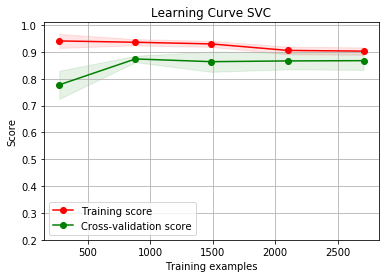

In [36]:
plot_learning_curve(estimator = grid_search_svc.best_estimator_,
                    title = "Learning Curve SVC",
                    X = tree_features_train,
                    y = tree_labels_train,
                    k_fold_splits = 5,
                    ylim=(0.2, 1.01),
                    n_jobs=4,
                    train_sizes = np.linspace(.1, 1.0, 5),
                    scoring_function = "f1")

Similarly as before the model didn't need more than 1000 observations to get a good cross-validation score and fit well. But this time we should have created a better model that is able to generalize well enough. Now we can tweak the hyperparameters and run a couple more Grid Searches, but I don't really see the point, since our model seems good enough based on the learning curve. After all we don't want to fit the error in the data as well.

So let's go straight to evaluating the model.

In [37]:
print(f1_score(tree_labels_test, grid_search_logistic.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_dtree.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_forest.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_lsvc.predict(tree_features_test)))
print(f1_score(tree_labels_test, grid_search_svc.predict(tree_features_test)))

0.6616541353383458
0.7361111111111112
0.7638888888888888
0.6349206349206349
0.8758169934640523


This time everything looks much better. We got a relatively high F1 score. Let's check the details on the other metrics.

In [38]:
precision_recall_fscore_support(tree_labels_test, grid_search_svc.best_estimator_.predict(tree_features_test))

(array([0.99201162, 0.89333333]),
 array([0.99417758, 0.85897436]),
 array([0.99309342, 0.87581699]),
 array([1374,   78], dtype=int64))

As can be seen, this time the precision is high and the recall is high as well thus the F1 score is also high. Now let's check the same score on the whole training dataset.

In [39]:
precision_recall_fscore_support(tree_labels_train, grid_search_svc.best_estimator_.predict(tree_features_train))

(array([0.99377141, 0.92613636]),
 array([0.99594257, 0.89071038]),
 array([0.99485581, 0.90807799]),
 array([3204,  183], dtype=int64))

Great, we are in the perfect case. The traning score is high, the same score on the testing data is also high, but a little bit lower than the training score. So we did not overfit the data and we did not suffer from high bias as well. We did what we could with an SVC algorithm.

Let's see now the ROC curve. I expect it to be perfect, because as we saw earlier from the precision, we don't really have a problem with false positives.

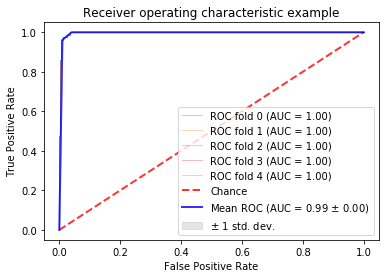

In [40]:
cv = StratifiedKFold(n_splits=5)
classifier = SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(tree_features_train, tree_labels_train):
    probas_ = classifier.fit(tree_features_train, tree_labels_train).predict_proba(tree_features_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(tree_labels_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Just as expected, the ROC curve is perfect.

One last thing we could try is to apply an outlier elimination algorithm on the training data to see if we can improve the accuracy and make the algorithm generalize even better. We may be able to squeeze out a little better F1 score.

### Model improvement through outlier elimination

We use a One Class SVM to perform outlier detection on the training data.

In [41]:
outliers_fraction = 0.15

one_class_svm = OneClassSVM(nu = outliers_fraction, kernel="rbf")

train_no_outlier_index = one_class_svm.fit(tree_features_train).predict(tree_features_train)

In [42]:
np.unique(train_no_outlier_index, return_counts = True)

(array([-1,  1], dtype=int64), array([ 508, 2879], dtype=int64))

We found 508 outliers in the training dataset. Let's create a new dataset without the outliers and train a new SVM model on it.

In [43]:
tree_features_no_outliers = tree_features_train[train_no_outlier_index == 1]
tree_labels_no_outliers = tree_labels_train[train_no_outlier_index == 1]

In [44]:
tuned_params = [{"C": [1, 5, 10, 20, 50, 100],
                 "gamma": [0.01, 0.1, 0.2, 0.5, 1]
                 }]

grid_search_svc_no_outliers = grid_search_cv(model = SVC(),
                                             params_to_tune = tuned_params,
                                             score_function = "f1",
                                             k_fold_splits = 5,
                                             attributes = tree_features_no_outliers,
                                             labels = tree_labels_no_outliers)

{'C': 20, 'gamma': 0.1}
SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8883877228093972


Let's see the learning curve.

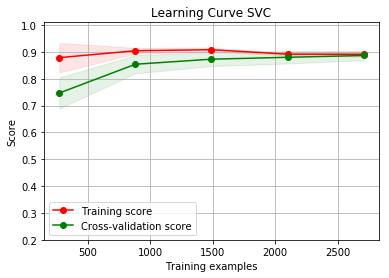

In [45]:
plot_learning_curve(estimator = grid_search_svc_no_outliers.best_estimator_,
                    title = "Learning Curve SVC",
                    X = tree_features_train,
                    y = tree_labels_train,
                    k_fold_splits = 5,
                    ylim=(0.2, 1.01),
                    n_jobs=4,
                    train_sizes = np.linspace(.1, 1.0, 5),
                    scoring_function = "f1")

Looks good, let's evaluate our new model on the testing dataset.

In [46]:
precision_recall_fscore_support(tree_labels_test, grid_search_svc_no_outliers.best_estimator_.predict(tree_features_test))

(array([0.99274311, 0.91891892]),
 array([0.99563319, 0.87179487]),
 array([0.99418605, 0.89473684]),
 array([1374,   78], dtype=int64))

We managed to squeeze out another 2 percent of the F1 score. Let's score the model on the training set without the outliers.

In [47]:
precision_recall_fscore_support(tree_labels_no_outliers, grid_search_svc_no_outliers.best_estimator_.predict(tree_features_no_outliers))

(array([0.99225664, 0.93413174]),
 array([0.99592894, 0.88135593]),
 array([0.9940894 , 0.90697674]),
 array([2702,  177], dtype=int64))

Looks perfect, the testing score is almost as good as the training score.

Well I think we did the best we could with our SVC model. One last thing we could do is save the model into a file for future use without having to go through all the training process.

### Saving the trained model to a file

In [48]:
# save the model to a file
filename = 'SVM_model_final.sav'
pickle.dump(grid_search_svc_no_outliers.best_estimator_, open(filename, 'wb'))

Now lets load the saved model and use it to predict a random 50 percent of the data that we have, just to check that it is working and that the F1 score is still good :)

In [49]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

_, test_model_features, _, test_model_labels = train_test_split(
    tree_features, tree_labels,
    train_size = 0.5, 
    test_size = 0.5,
    stratify = tree_labels)

print(f1_score(test_model_labels, loaded_model.predict(test_model_features)))

0.8984375


Looks good.

### Final conclusions

We tried to train a model on the provided training dataset. However there were very few positive observations in this dataset and our model failed to generalize well, which caused it to behave poorly over the testing dataset. Trying different approaches we could not improve the model Recall score. One thing that is worth trying as future work here is trying some unsupervised learning algorithms for anomaly detection which may be able to correctly classify the data that they have never seen before.

On our second attempt, we united all the data that was available to us in a single dataset and did a random shuffled train-test split ourselves. We easily created a good kernel SVM model with a relatively high F1 score on the training dataset. We drew conclusions based on the learning curve, ROC curve and other scores. After that we tried to improve the model through One-class SVM outlier detection algorithm and were able to improve its score by 2%.

Going back to the original question that we are trying to answer: We are able to use Machine Learning in detection of areas of diseased trees based on sattelite images provided, using a kernel SVM Machine Learning algorithm, which will guess a roughly 90% of all diseased trees.

As future work, we can try other Machine Learning algorithms in the hope of achieving even better results. We can also try with unsupervised learning algorithms.

### References 

* [QuickBird satellite sensor description](https://www.satimagingcorp.com/satellite-sensors/quickbird/)
* [UCI Wilt Data Set](https://archive.ics.uci.edu/ml/datasets/Wilt)
* [Save and Load Machine Learning Models in Python with scikit-learn](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)
